# SETUP

## Check environment

In [1]:
USE_GPU = True

## Libraries

In [2]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging
import sys

# Data
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import joblib

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
from scipy.stats import pearsonr
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.losses import MeanAbsoluteError, MeanSquaredError
import keras.backend as K
from tqdm.keras import TqdmCallback
from tensorflow.keras import optimizers

# Append the custom libraries to system path
sys.path.append("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project")

# Configure device
if not USE_GPU:
    print("Using CPU to train")
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else:
    print("Using GPU to train")
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true"

# Custom libraries written by myself
from src.plot import plot_1_data, plot_2_data, plot_3_data, plot_prediction, plot_learning_curves
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import LSTMPrediction, inferenceLSTM
from src.loop_model import generate_loopresults, choose_the_best
from src.reduce_data_utils import prepareReducedData
from src.data_utils import mice
from src.time_series_utils import splitTrainValidationTestTimeSeries, reframePastFuture, padPastFuture

# Configuration reader
from src.config_reader import ConfigurationReader

# Checking Tensorflow
print(f"Tensorflow version: {tf.__version__}, GPUs: {tf.config.list_physical_devices('GPU')}")

E0000 00:00:1762568412.572773  338735 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762568412.579728  338735 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762568412.596899  338735 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762568412.596934  338735 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762568412.596936  338735 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762568412.596938  338735 computation_placer.cc:177] computation placer already registered. Please check linka

Using GPU to train
Tensorflow version: 2.19.1, GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# DATA FROM VIET

## Load dataset

In [4]:
dataset_path = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station"

df_raw = []

for csv_file in sorted(glob.glob(f"{dataset_path}/*")):
    print(f"Working on {csv_file}")
    df_station = pd.read_csv(csv_file)
    df_station["station"] = int(os.path.splitext(os.path.basename(csv_file))[0])
    df_raw.append(df_station)
df_raw = pd.concat(df_raw, axis=0)

# Lowercase columns name
df_raw.columns = df_raw.columns.map(lambda col: col.lower().strip())

# Set time index
df_raw["date"] = pd.to_datetime(df_raw["date"])
df_raw.set_index("date", inplace=True)

# Drop columns
features_to_use = ["pm25_quantrac", "tsp_quantrac", "station"]
df_raw = df_raw.loc[:, features_to_use]

df_raw

Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station/211.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station/212.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station/213.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station/214.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station/215.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station/216.csv


pm25_quantrac  tsp_quantrac  station
date                                                     
2021-02-23 21:00:00      15.604762     32.935714      211
2021-02-23 22:00:00      14.594118     30.932353      211
2021-02-23 23:00:00      13.436667     27.645000      211
2021-02-24 00:00:00      12.365000     24.380000      211
2021-02-24 01:00:00      11.636667     22.521667      211
...                            ...           ...      ...
2022-12-31 19:00:00      41.450000    107.451667      216
2022-12-31 20:00:00      50.530000    126.168333      216
2022-12-31 21:00:00      55.055000    139.688333      216
2022-12-31 22:00:00      26.078333     63.565000      216
2022-12-31 23:00:00      21.161667     51.705000      216

[92966 rows x 3 columns]

## Data preparation

### Drop missing

In [5]:
df = []
for station in sorted(df_raw["station"].unique()):
    df_station = df_raw[df_raw["station"] == station]
    df.append(df_station.dropna())
df = pd.concat(df, axis=0)
df

pm25_quantrac  tsp_quantrac  station
date                                                     
2021-02-23 21:00:00      15.604762     32.935714      211
2021-02-23 22:00:00      14.594118     30.932353      211
2021-02-23 23:00:00      13.436667     27.645000      211
2021-02-24 00:00:00      12.365000     24.380000      211
2021-02-24 01:00:00      11.636667     22.521667      211
...                            ...           ...      ...
2022-12-31 19:00:00      41.450000    107.451667      216
2022-12-31 20:00:00      50.530000    126.168333      216
2022-12-31 21:00:00      55.055000    139.688333      216
2022-12-31 22:00:00      26.078333     63.565000      216
2022-12-31 23:00:00      21.161667     51.705000      216

[49923 rows x 3 columns]

### Scale

In [6]:
df_scaled = copy.deepcopy(df)

# Scale features
features_to_scale = ["tsp_quantrac"]
for f in features_to_scale:
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[[f]])
    df_scaled[f] = scaled_data

# Scale label
label = "pm25_quantrac"
label_scaler = MinMaxScaler()
df_scaled[label] = label_scaler.fit_transform(df[[label]])

# Drop station column
df_scaled = df_scaled.drop(columns=["station"], errors="ignore")

df_scaled

pm25_quantrac  tsp_quantrac
date                                            
2021-02-23 21:00:00       0.096032      0.091311
2021-02-23 22:00:00       0.089813      0.085757
2021-02-23 23:00:00       0.082690      0.076643
2021-02-24 00:00:00       0.076095      0.067591
2021-02-24 01:00:00       0.071612      0.062439
...                            ...           ...
2022-12-31 19:00:00       0.255085      0.297899
2022-12-31 20:00:00       0.310963      0.349789
2022-12-31 21:00:00       0.338810      0.387272
2022-12-31 22:00:00       0.160487      0.176228
2022-12-31 23:00:00       0.130230      0.143347

[49923 rows x 2 columns]

### Train test split

In [8]:
splitter = round(0.8 * len(df_scaled))
train_data = df_scaled.iloc[:splitter]
test_data = df_scaled.iloc[splitter:]

display(train_data)
display(test_data)

pm25_quantrac  tsp_quantrac
date                                            
2021-02-23 21:00:00       0.096032      0.091311
2021-02-23 22:00:00       0.089813      0.085757
2021-02-23 23:00:00       0.082690      0.076643
2021-02-24 00:00:00       0.076095      0.067591
2021-02-24 01:00:00       0.071612      0.062439
...                            ...           ...
2021-09-21 06:00:00       0.059110      0.052214
2021-09-21 07:00:00       0.065058      0.058590
2021-09-21 08:00:00       0.067930      0.060540
2021-09-21 09:00:00       0.062597      0.054857
2021-09-21 10:00:00       0.061017      0.051631

[39938 rows x 2 columns]

pm25_quantrac  tsp_quantrac
date                                            
2021-09-21 11:00:00       0.065315      0.057731
2021-09-21 12:00:00       0.059551      0.050703
2021-09-21 13:00:00       0.058597      0.048018
2021-09-21 14:00:00       0.053520      0.039493
2021-09-21 15:00:00       0.064546      0.053170
...                            ...           ...
2022-12-31 19:00:00       0.255085      0.297899
2022-12-31 20:00:00       0.310963      0.349789
2022-12-31 21:00:00       0.338810      0.387272
2022-12-31 22:00:00       0.160487      0.176228
2022-12-31 23:00:00       0.130230      0.143347

[9985 rows x 2 columns]

## Prediction

### Model paramaters

In [9]:
n_past = 168
n_future = 4
latent_dim = 32

epochs = 100
batch_size = 128

In [10]:
# Calculate MNBE
def mean_normalized_bias_error(y_pred, y_actual):
    y_pred = np.array(y_pred)
    y_actual = np.array(y_actual)
    return np.mean((y_pred - y_actual) / np.mean(y_actual)) * 100

metrics_calculators = {
    "mae": mean_absolute_error,
    "mse": mean_squared_error,
    "rmse": root_mean_squared_error,
    "r2": r2_score,
    "mape": mean_absolute_percentage_error,
    "mnbe": mean_normalized_bias_error,
    "r_coeff": lambda a,b: pearsonr(a, b)[0]
}

### Reframe data

In [11]:
# Function to reframe data
def reframe(input_data, n_past, n_future, n_shifted=0):
    data = copy.deepcopy(input_data)
    m = np.arange(0, len(data) - n_past - n_future - n_shifted + 1)
    X = np.array([data.iloc[i:(i + n_past), :] for i in m])
    label_index_col = 0
    y = np.expand_dims(np.array([data.iloc[(i + n_shifted + n_past):(i + n_shifted + n_past + n_future), 0] for i in m]), -1)
    return X, y

X_train, y_train = reframe(train_data, n_past, n_future)
X_test, y_test = reframe(test_data, n_past, n_future)

X_train_shifted_1, y_train_shifted_1 = reframe(train_data, n_past, n_future, 1)
X_test_shifted_1, y_test_shifted_1 = reframe(test_data, n_past, n_future, 1)
print(X_train_shifted_1.shape, y_train_shifted_1.shape, X_test_shifted_1.shape, y_test_shifted_1.shape)

X_train_shifted_2, y_train_shifted_2 = reframe(train_data, n_past, n_future, 2)
X_test_shifted_2, y_test_shifted_2 = reframe(test_data, n_past, n_future, 2)
print(X_train_shifted_2.shape, y_train_shifted_2.shape, X_test_shifted_2.shape, y_test_shifted_2.shape)

X_train_shifted_3, y_train_shifted_3 = reframe(train_data, n_past, n_future, 3)
X_test_shifted_3, y_test_shifted_3 = reframe(test_data, n_past, n_future, 3)
print(X_train_shifted_3.shape, y_train_shifted_3.shape, X_test_shifted_3.shape, y_test_shifted_3.shape)

X_train_shifted_4, y_train_shifted_4 = reframe(train_data, n_past, n_future, 4)
X_test_shifted_4, y_test_shifted_4 = reframe(test_data, n_past, n_future, 4)
print(X_train_shifted_4.shape, y_train_shifted_4.shape, X_test_shifted_4.shape, y_test_shifted_4.shape)

(39766, 168, 2) (39766, 4, 1) (9813, 168, 2) (9813, 4, 1)
(39765, 168, 2) (39765, 4, 1) (9812, 168, 2) (9812, 4, 1)
(39764, 168, 2) (39764, 4, 1) (9811, 168, 2) (9811, 4, 1)
(39763, 168, 2) (39763, 4, 1) (9810, 168, 2) (9810, 4, 1)


In [12]:
print(X_train_shifted_3[0])
print(y_train_shifted_3[0])
print(train_data[0:176].values)

[[0.09603226 0.09131097]
 [0.08981272 0.08575685]
 [0.08268972 0.07664299]
 [0.07609465 0.06759111]
 [0.07161246 0.06243906]
 [0.07095603 0.06139017]
 [0.06918162 0.05980529]
 [0.06849442 0.05818805]
 [0.06806363 0.0581095 ]
 [0.0687816  0.05916763]
 [0.07252531 0.0651514 ]
 [0.09661836 0.09275988]
 [0.19016995 0.20131781]
 [0.25600788 0.27218805]
 [0.1653897  0.16205832]
 [0.15137902 0.14969573]
 [0.12269095 0.11246702]
 [0.10249546 0.09406753]
 [0.10025583 0.09515272]
 [0.09427982 0.09007065]
 [0.12459871 0.12662474]
 [0.12639363 0.12634288]
 [0.11242397 0.11280433]
 [0.10259803 0.09967239]
 [0.09669015 0.09232554]
 [0.09633117 0.09152616]
 [0.09597218 0.09048651]
 [0.09345929 0.08650812]
 [0.09443367 0.08728439]
 [0.09390033 0.08960858]
 [0.09118229 0.08767714]
 [0.08528468 0.07826947]
 [0.08093582 0.07168964]
 [0.08073069 0.07284019]
 [0.08341795 0.07706809]
 [0.08898948 0.08724455]
 [0.14280988 0.15597033]
 [0.14280988 0.15597033]
 [0.07754085 0.0720824 ]
 [0.11227495 0.10175523]


### LSTM-Seq2Seq

In [13]:
def define_lstms2s_model(n_past, n_future, n_features, n_label, name="model"):
    # Encoder layers
    encoder_inputs = Input(shape=(n_past, n_features))
    encoder_lstm_1 = LSTM(128, return_sequences=True, activation="relu")(encoder_inputs)
    encoder_lstm_2, state_h, state_c = LSTM(64, return_state=True, activation="relu", dropout=0.2)(encoder_lstm_1)
    encoder_dense = Dense(latent_dim)(encoder_lstm_2)
    # Repeat layer
    decoder_repeat_vector = RepeatVector(n_future)(encoder_dense)
    # Decoder layers
    decoder_lstm_1 = LSTM(64, return_sequences=True, activation="relu")(decoder_repeat_vector, initial_state=[state_h, state_c])
    decoder_lstm_2 = LSTM(128, return_sequences=True, activation="relu", dropout=0.2)(decoder_lstm_1)
    decoder_outputs = TimeDistributed(Dense(n_label))(decoder_lstm_2)

    # Compile the model
    model = Model(encoder_inputs, decoder_outputs)
    model.name = name
    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError())
    display(model.summary())
    return model

#### No shift

I0000 00:00:1762568468.205952  338735 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 36439 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:b1:00.0, compute capability: 8.0


Model: "lstms2s_no_shift"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 168, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 168, 128)  │     67,072 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 64),      │     49,408 │ lstm[0][0]        │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      2,080 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 4, 32)     │          0 │ dense[0][0]       │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 4, 64)     │     24,832 │ repeat_vector[0]… │
│                     │                   │            │ lstm_1[0][1],     │
│                     │                   │            │ lstm_1[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 4, 128)    │     98,816 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 4, 1)      │        129 │ lstm_3[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 242,337 (946.63 KB)

 Trainable params: 242,337 (946.63 KB)

 Non-trainable params: 0 (0.00 B)

None

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/100


I0000 00:00:1762568475.914615  338829 service.cc:152] XLA service 0x7b5388014410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762568475.914652  338829 service.cc:160]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
I0000 00:00:1762568477.701464  338829 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762568495.823834  338829 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


249/249 ━━━━━━━━━━━━━━━━━━━━ 54s 116ms/step - loss: 0.0521 - val_loss: 0.0296
Epoch 2/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - loss: 0.0497 - val_loss: 0.0286
Epoch 3/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - loss: 0.0439 - val_loss: 0.0287
Epoch 4/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 0.0420 - val_loss: 0.0278
Epoch 5/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 24s 57ms/step - loss: 0.0397 - val_loss: 0.0262
Epoch 6/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - loss: 0.0382 - val_loss: 0.0246
Epoch 7/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - loss: 0.0368 - val_loss: 0.0229
Epoch 8/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - loss: 0.0365 - val_loss: 0.0230
Epoch 9/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - loss: 0.0357 - val_loss: 0.0219
Epoch 10/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 54s 216ms/step - loss: 0.0354 - val_loss: 0.0217
Epoch 11/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - loss: 0.0351 - val_loss: 0.0213
Epoch 12/100
249/249 ━━━━━━━━

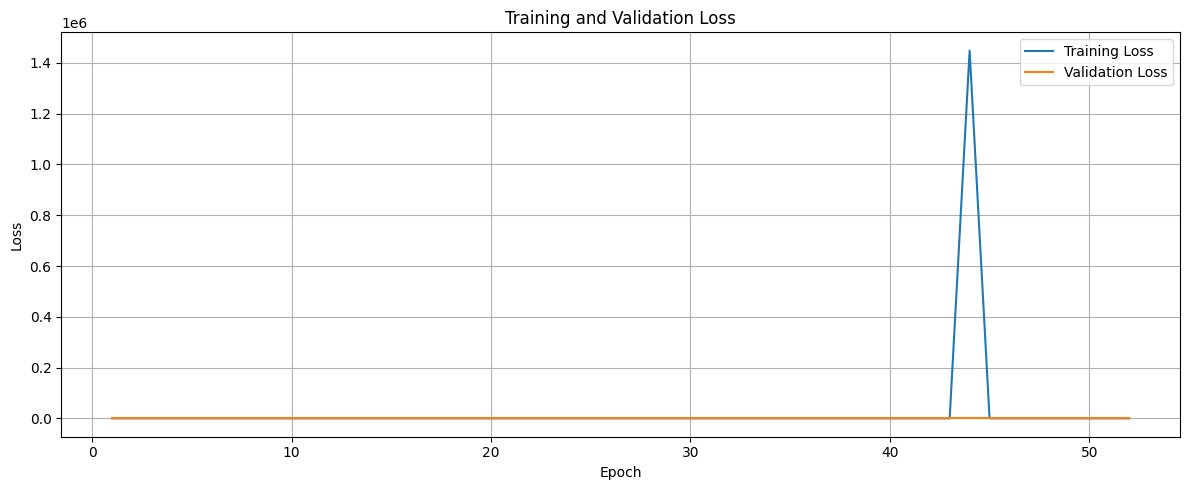

307/307 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step
Day = 0


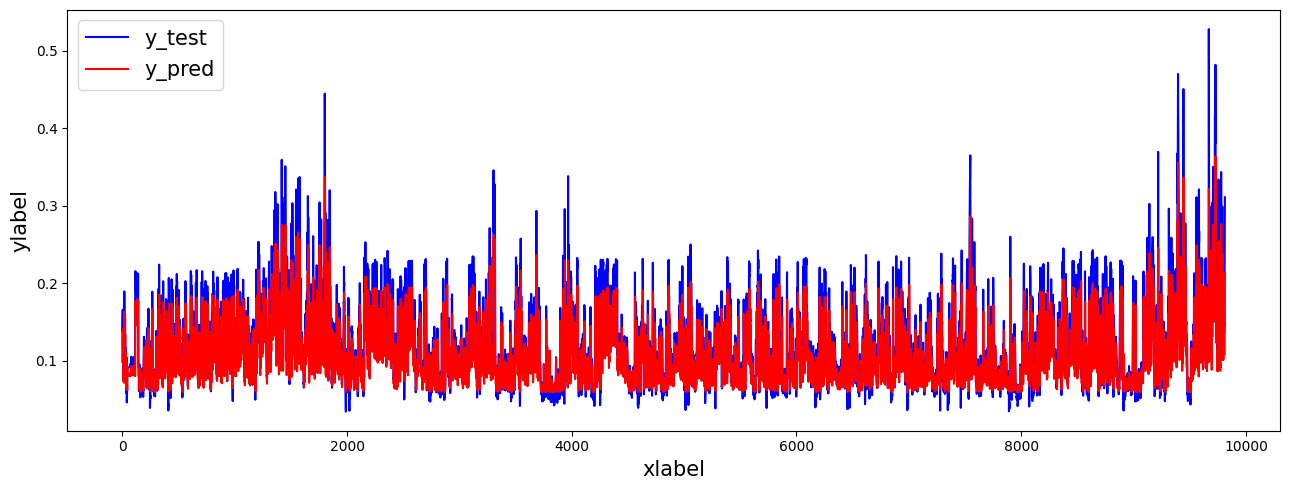

mae: 2.3301807423010654
mse: 9.283455867755647
rmse: 3.0468764116313687
r2: 0.7730037278570538
mape: 0.12391048996072664
mnbe: -10.701423018631637
r_coeff: [0.98814747]


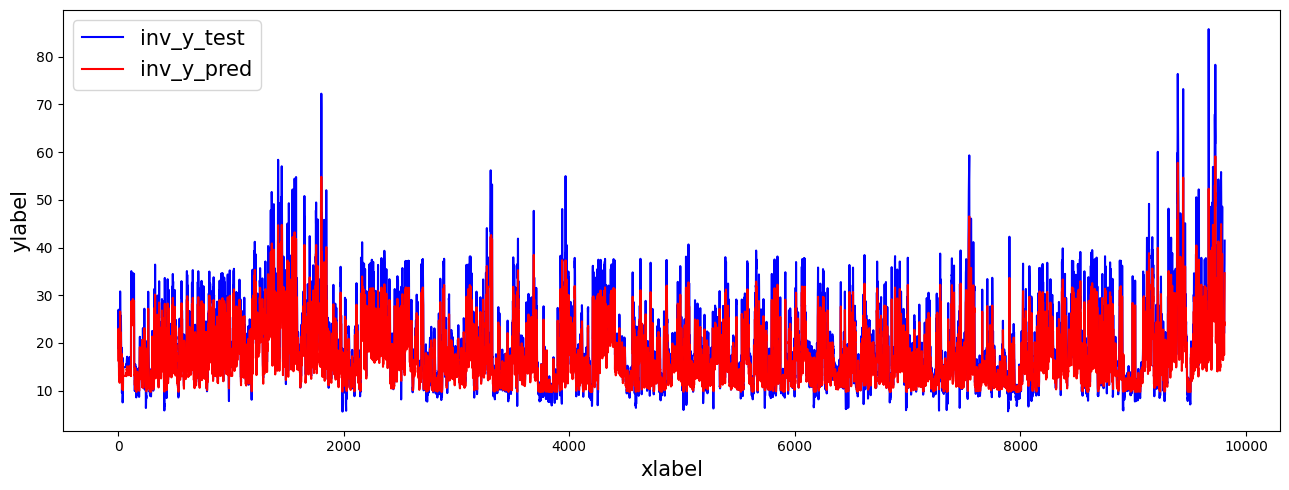

Day = 1


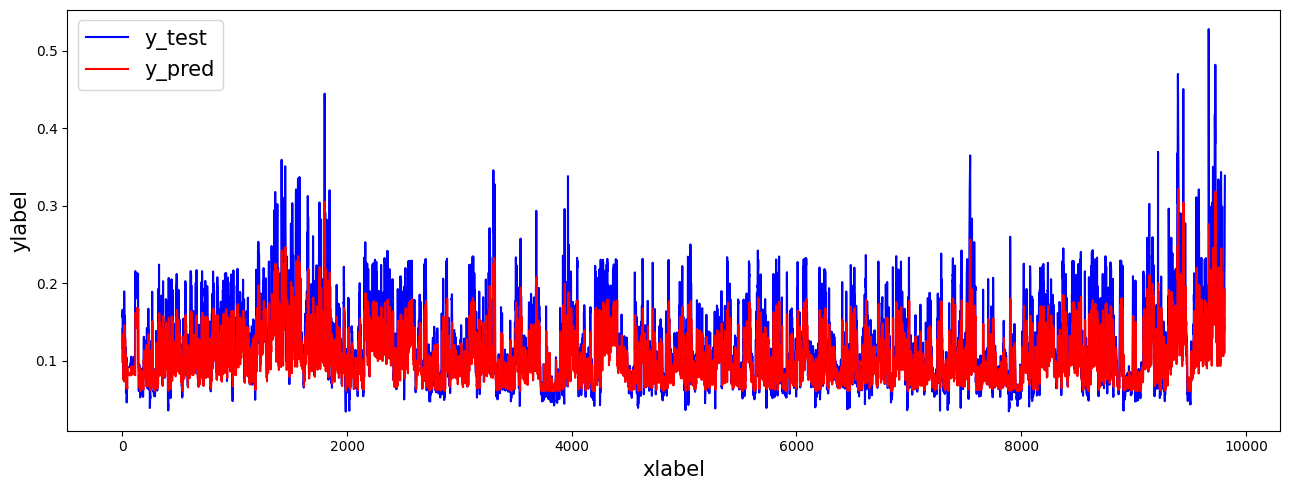

mae: 2.7016720528569276
mse: 14.92269524517324
rmse: 3.862990453673584
r2: 0.5065645185796153
mape: 0.13795362284813198
mnbe: -12.276801247825828
r_coeff: [0.98606751]


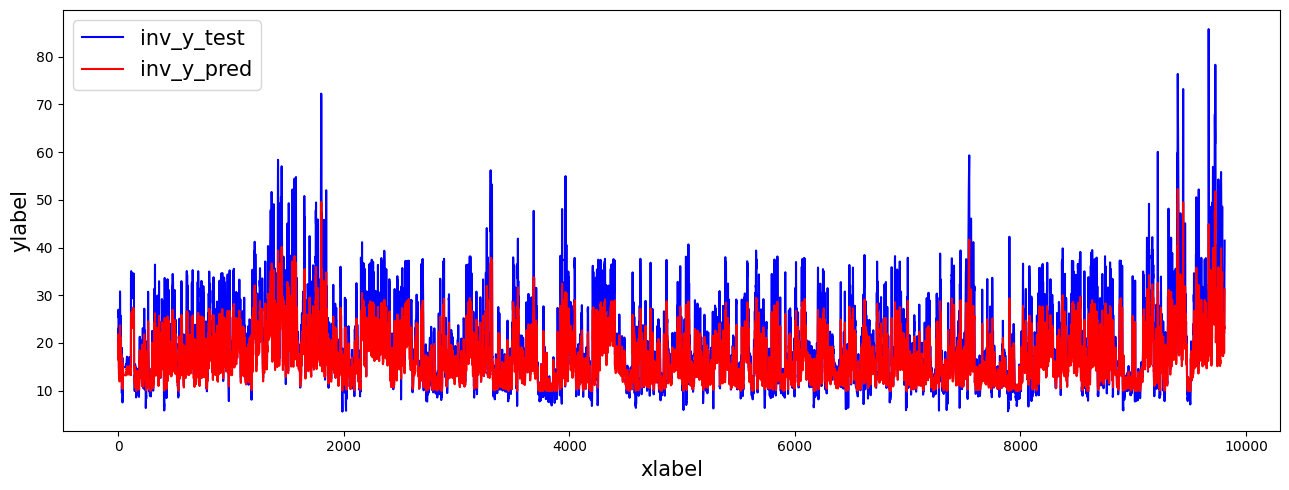

Day = 2


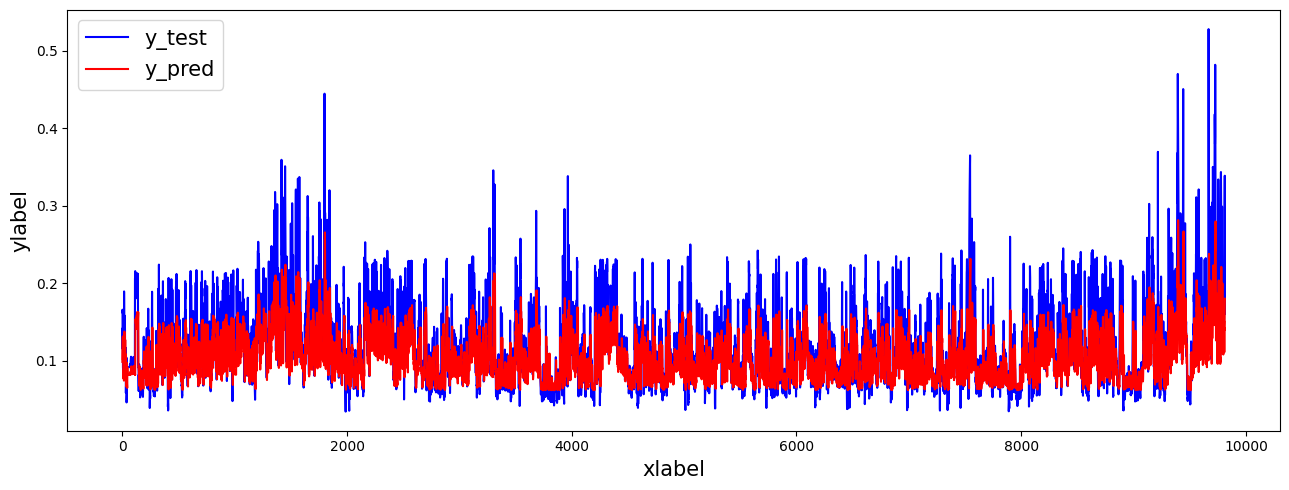

mae: 2.891300562261584
mse: 18.99890929627615
rmse: 4.358773829447468
r2: 0.24461921450207913
mape: 0.14682178261038
mnbe: -12.930184528656966
r_coeff: [0.9789568]


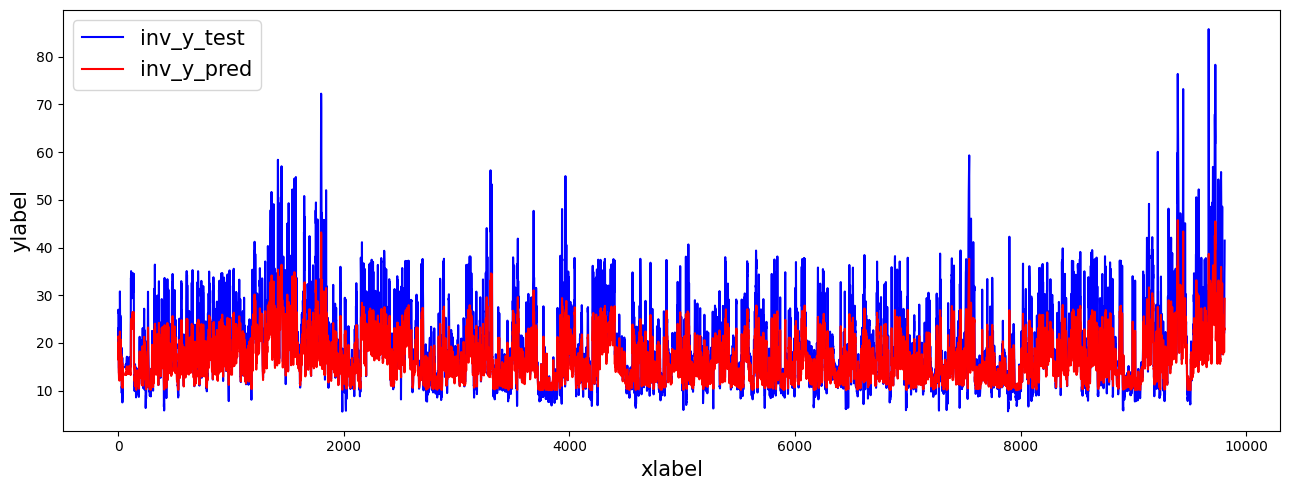

Day = 3


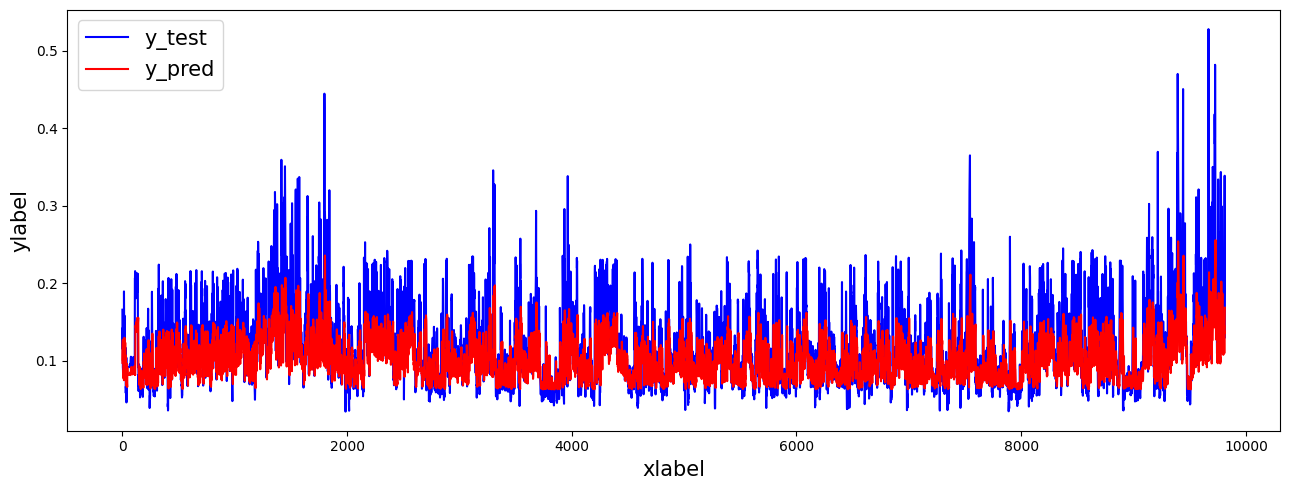

mae: 3.2360959258288946
mse: 24.43483583667403
rmse: 4.9431605109154635
r2: -0.1938586725427207
mape: 0.16723067845406628
mnbe: -14.49917083142851
r_coeff: [0.97224044]


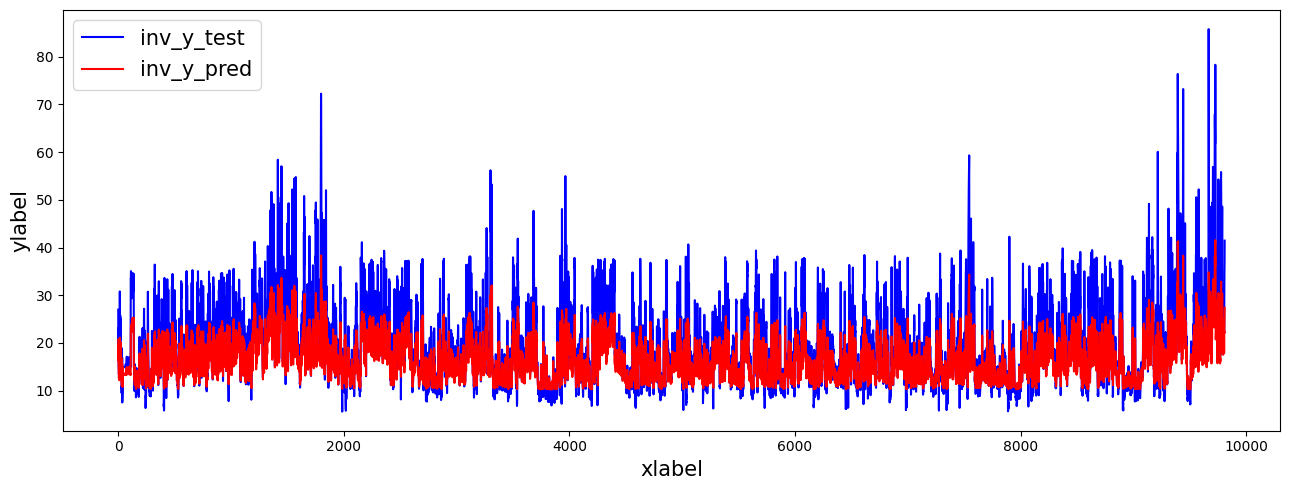

In [14]:
lstms2s = define_lstms2s_model(n_past, n_future, X_train.shape[-1], y_train.shape[-1], "lstms2s_no_shift")

history = lstms2s.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred = lstms2s.predict(X_test)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    current_day_y_pred, current_day_y_test = y_pred[:, day, :], y_test[:, day, :]
    plot_2_data(data1=current_day_y_test, datalabel1="y_test", data2=current_day_y_pred, datalabel2="y_pred")
    inv_y_test, inv_y_pred = label_scaler.inverse_transform(current_day_y_test)[:-(day+1)], label_scaler.inverse_transform(current_day_y_pred)[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="inv_y_test", data2=inv_y_pred, datalabel2="inv_y_pred")

#### Shifted 1

In [15]:
lstms2s_shifted_1 = define_lstms2s_model(n_past, n_future, X_train_shifted_1.shape[-1], y_train_shifted_1.shape[-1], "lstms2s_shifted_1")

history = lstms2s_shifted_1.fit(X_train_shifted_1, y_train_shifted_1,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred_shifted_1 = lstms2s_shifted_1.predict(X_test_shifted_1)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    current_day_y_pred, current_day_y_test = y_pred_shifted_1[:, day, :], y_test_shifted_1[:, day, :]
    plot_2_data(data1=current_day_y_test, datalabel1="y_test", data2=current_day_y_pred, datalabel2="y_pred")
    inv_y_test, inv_y_pred = label_scaler.inverse_transform(current_day_y_test)[:-(day+1)], label_scaler.inverse_transform(current_day_y_pred)[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="inv_y_test", data2=inv_y_pred, datalabel2="inv_y_pred")

Model: "lstms2s_shifted_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 168, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 168, 128)  │     67,072 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 64),      │     49,408 │ lstm_4[0][0]      │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 4, 32)     │          0 │ dense_2[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 4, 64)     │     24,832 │ repeat_vector_1[… │
│                     │                   │            │ lstm_5[0][1],     │
│                     │                   │            │ lstm_5[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 4, 128)    │     98,816 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 4, 1)      │        129 │ lstm_7[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 242,337 (946.63 KB)

 Trainable params: 242,337 (946.63 KB)

 Non-trainable params: 0 (0.00 B)

None

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 92s 315ms/step - loss: 0.0521 - val_loss: 0.0328
Epoch 2/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - loss: 0.0506 - val_loss: 0.0294
Epoch 3/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 33s 131ms/step - loss: 0.0494 - val_loss: 0.0297
Epoch 4/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - loss: 0.0467 - val_loss: 0.0287
Epoch 5/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - loss: 0.0448 - val_loss: 0.0287
Epoch 6/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 35s 139ms/step - loss: 0.0407 - val_loss: 0.0263
Epoch 9/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - loss: 0.0401 - val_loss: 0.0261
Epoch 10/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - loss: 0.0395 - val_loss: 0.0256
Epoch 11/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 34s 132ms/step - loss: 0.0393 - val_loss: 0.0255
Epoch 12/100
176/249 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - loss: 0.0382

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



#### Shifted 2

In [16]:
lstms2s_shifted_2 = define_lstms2s_model(n_past, n_future, X_train_shifted_2.shape[-1], y_train_shifted_2.shape[-1], "lstms2s_shifted_2")

history = lstms2s_shifted_2.fit(X_train_shifted_2, y_train_shifted_2,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred_shifted_2 = lstms2s_shifted_2.predict(X_test_shifted_2)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    current_day_y_pred, current_day_y_test = y_pred_shifted_2[:, day, :], y_test_shifted_2[:, day, :]
    plot_2_data(data1=current_day_y_test, datalabel1="y_test", data2=current_day_y_pred, datalabel2="y_pred")
    inv_y_test, inv_y_pred = label_scaler.inverse_transform(current_day_y_test)[:-(day+1)], label_scaler.inverse_transform(current_day_y_pred)[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="inv_y_test", data2=inv_y_pred, datalabel2="inv_y_pred")

Model: "lstms2s_shifted_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 168, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 168, 128)  │     67,072 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ [(None, 64),      │     49,408 │ lstm_8[0][0]      │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 4, 32)     │          0 │ dense_4[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 4, 64)     │     24,832 │ repeat_vector_2[… │
│                     │                   │            │ lstm_9[0][1],     │
│                     │                   │            │ lstm_9[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 4, 128)    │     98,816 │ lstm_10[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 4, 1)      │        129 │ lstm_11[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 242,337 (946.63 KB)

 Trainable params: 242,337 (946.63 KB)

 Non-trainable params: 0 (0.00 B)

None

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - loss: 0.0526 - val_loss: 0.0324
Epoch 2/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 0.0510 - val_loss: 0.0289
Epoch 3/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 0.0494 - val_loss: 0.0318
Epoch 4/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 0.0494 - val_loss: 0.0306
Epoch 5/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 0.0472 - val_loss: 0.0292
Epoch 6/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.0452 - val_loss: 0.0281
Epoch 7/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.0442 - val_loss: 0.0276
Epoch 8/100
190/249 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0420

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



#### Shifted 3

In [17]:
lstms2s_shifted_3 = define_lstms2s_model(n_past, n_future, X_train_shifted_3.shape[-1], y_train_shifted_3.shape[-1], "lstms2s_shifted_3")

history = lstms2s_shifted_3.fit(X_train_shifted_3, y_train_shifted_3,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred_shifted_3 = lstms2s_shifted_3.predict(X_test_shifted_3)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    current_day_y_pred, current_day_y_test = y_pred_shifted_3[:, day, :], y_test_shifted_3[:, day, :]
    plot_2_data(data1=current_day_y_test, datalabel1="y_test", data2=current_day_y_pred, datalabel2="y_pred")
    inv_y_test, inv_y_pred = label_scaler.inverse_transform(current_day_y_test)[:-(day+1)], label_scaler.inverse_transform(current_day_y_pred)[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="inv_y_test", data2=inv_y_pred, datalabel2="inv_y_pred")

Model: "lstms2s_shifted_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 168, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 168, 128)  │     67,072 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ [(None, 64),      │     49,408 │ lstm_12[0][0]     │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      2,080 │ lstm_13[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_3     │ (None, 4, 32)     │          0 │ dense_6[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 4, 64)     │     24,832 │ repeat_vector_3[… │
│                     │                   │            │ lstm_13[0][1],    │
│                     │                   │            │ lstm_13[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 4, 128)    │     98,816 │ lstm_14[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 4, 1)      │        129 │ lstm_15[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 242,337 (946.63 KB)

 Trainable params: 242,337 (946.63 KB)

 Non-trainable params: 0 (0.00 B)

None

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 49s 140ms/step - loss: 0.0525 - val_loss: 0.0300
Epoch 2/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0506 - val_loss: 0.0292
Epoch 3/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0496 - val_loss: 0.0307
Epoch 4/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0486 - val_loss: 0.0300
Epoch 5/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 0.0469 - val_loss: 0.0287
Epoch 6/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 0.0449 - val_loss: 0.0286
Epoch 7/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - loss: 0.0451 - val_loss: 0.0280
Epoch 8/100
189/249 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0426

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



#### Shifted 4

In [18]:
lstms2s_shifted_4 = define_lstms2s_model(n_past, n_future, X_train_shifted_4.shape[-1], y_train_shifted_4.shape[-1], "lstms2s_shifted_4")

history = lstms2s_shifted_4.fit(X_train_shifted_4, y_train_shifted_4,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred_shifted_4 = lstms2s_shifted_4.predict(X_test_shifted_4)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    current_day_y_pred, current_day_y_test = y_pred_shifted_4[:, day, :], y_test_shifted_4[:, day, :]
    plot_2_data(data1=current_day_y_test, datalabel1="y_test", data2=current_day_y_pred, datalabel2="y_pred")
    inv_y_test, inv_y_pred = label_scaler.inverse_transform(current_day_y_test)[:-(day+1)], label_scaler.inverse_transform(current_day_y_pred)[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="inv_y_test", data2=inv_y_pred, datalabel2="inv_y_pred")

Model: "lstms2s_shifted_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 168, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ (None, 168, 128)  │     67,072 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ [(None, 64),      │     49,408 │ lstm_16[0][0]     │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │      2,080 │ lstm_17[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_4     │ (None, 4, 32)     │          0 │ dense_8[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 4, 64)     │     24,832 │ repeat_vector_4[… │
│                     │                   │            │ lstm_17[0][1],    │
│                     │                   │            │ lstm_17[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ (None, 4, 128)    │     98,816 │ lstm_18[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 4, 1)      │        129 │ lstm_19[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 242,337 (946.63 KB)

 Trainable params: 242,337 (946.63 KB)

 Non-trainable params: 0 (0.00 B)

None

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 44s 132ms/step - loss: 0.0521 - val_loss: 0.0316
Epoch 2/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - loss: 0.0508 - val_loss: 0.0290
Epoch 3/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0505 - val_loss: 0.0305
Epoch 4/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.0491 - val_loss: 0.0289
Epoch 5/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - loss: 0.0481 - val_loss: 0.0295
Epoch 6/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.0467 - val_loss: 0.0284
Epoch 7/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - loss: 0.0458 - val_loss: 0.0279
Epoch 8/100
190/249 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0432

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



### GRU-Seq2Seq

In [19]:
def define_grus2s_model(n_past, n_future, n_features, n_label, name="model"):
    # encoder layers
    encoder_inputs = Input(shape=(n_past, n_features))
    encoder_gru_1 = GRU(128, return_sequences=True, activation="relu")(encoder_inputs)
    encoder_gru_2, state_h = GRU(64, return_state=True, activation="relu")(encoder_gru_1)
    encoder_dropout = Dropout(0.2)(encoder_gru_2)
    encoder_dense = Dense(latent_dim)(encoder_dropout)
    # Repeat layer
    decoder_repeat_vector = RepeatVector(n_future)(encoder_dense)
    # Decoder layers
    decoder_gru_1 = GRU(64, return_sequences=True, activation="relu")(decoder_repeat_vector, initial_state=state_h)
    decoder_gru_2 = GRU(128, return_sequences=True, activation="relu")(decoder_gru_1)
    decoder_dropout = Dropout(0.2)(decoder_gru_2)
    decoder_outputs = TimeDistributed(Dense(n_label))(decoder_dropout)
    # Compile the model
    model = Model(encoder_inputs, decoder_outputs)
    model.name = name
    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
    display(model.summary())
    return model

#### No shift

Model: "grus2s_no_shift"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 168, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 168, 128)  │     50,688 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ [(None, 64),      │     37,248 │ gru[0][0]         │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_5     │ (None, 4, 32)     │          0 │ dense_10[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 4, 64)     │     18,816 │ repeat_vector_5[… │
│                     │                   │            │ gru_1[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 4, 128)    │     74,496 │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 4, 128)    │          0 │ gru_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 4, 1)      │        129 │ dropout_1[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 183,457 (716.63 KB)

 Trainable params: 183,457 (716.63 KB)

 Non-trainable params: 0 (0.00 B)

None

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 51s 118ms/step - loss: 0.0046 - val_loss: 0.0017
Epoch 2/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - loss: 0.0036 - val_loss: 0.0014
Epoch 3/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 4/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 5/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.0031 - val_loss: 0.0010
Epoch 6/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - loss: 0.0030 - val_loss: 0.0010
Epoch 7/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - loss: 0.0030 - val_loss: 0.0010
Epoch 8/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 0.0029 - val_loss: 9.7993e-04
Epoch 9/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - loss: 0.0029 - val_loss: 9.9255e-04
Epoch 10/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.0029 - val_loss: 9.9517e-04
Epoch 11/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - loss: 0.0028 - val_loss: 9.9465e-04
Ep

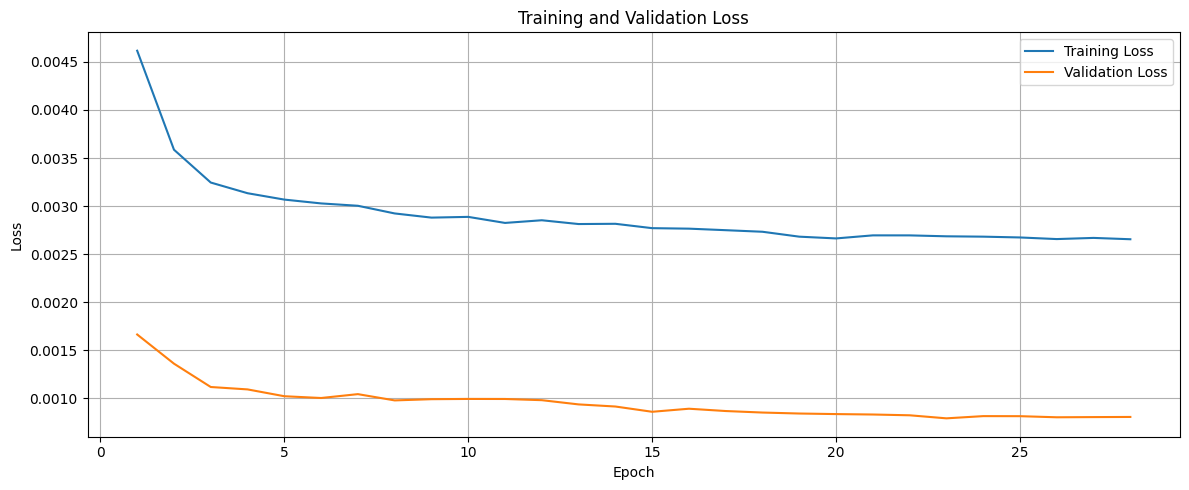

307/307 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step
Day = 0
mae: 2.5681376764815704
mse: 8.938939187951128
rmse: 2.9898058779711985
r2: 0.8110505149424797
mape: 0.14938570890633937
mnbe: -12.388428082999528
r_coeff: [0.99028782]


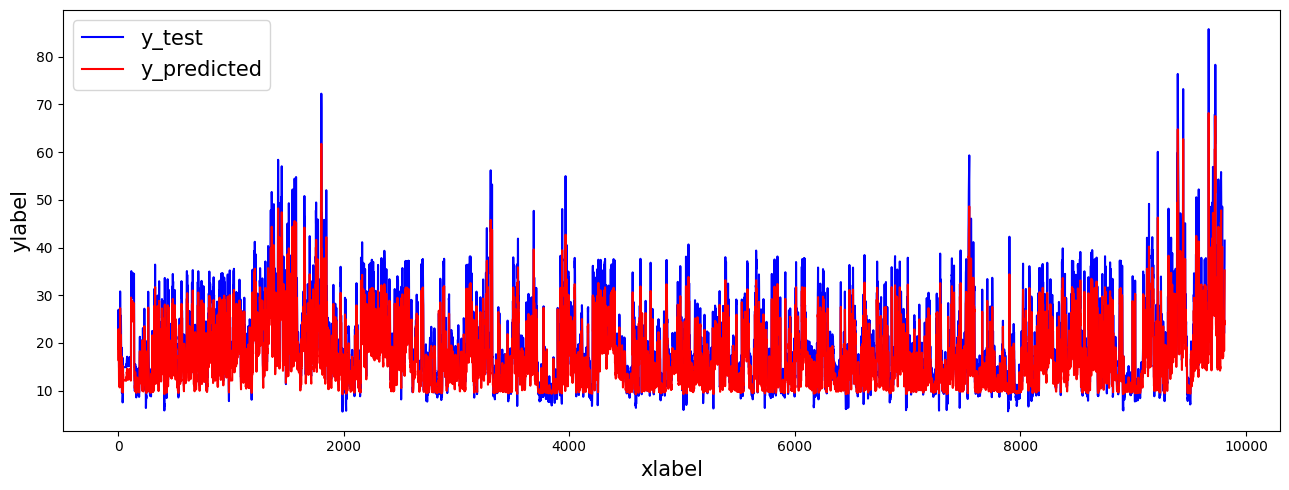

Day = 1
mae: 2.5023427462515357
mse: 10.098183027048432
rmse: 3.1777638406666457
r2: 0.7519258607253448
mape: 0.13753247787974998
mnbe: -11.503145943454332
r_coeff: [0.98723589]


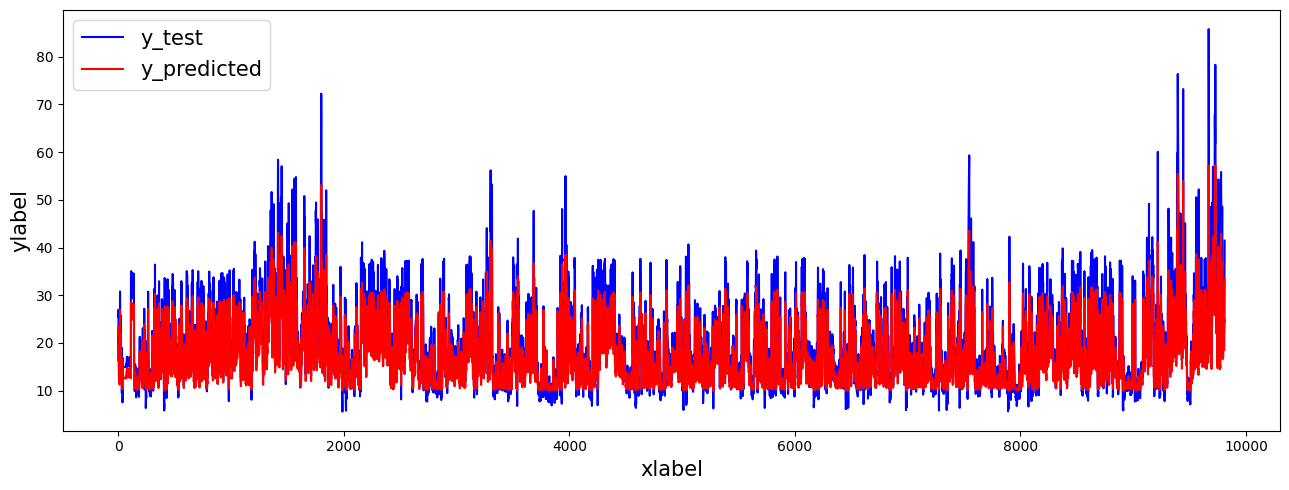

Day = 2
mae: 2.49552820574061
mse: 12.360176377118181
rmse: 3.5157042505191165
r2: 0.6116722850716954
mape: 0.12887372621672863
mnbe: -9.976807243283051
r_coeff: [0.98508398]


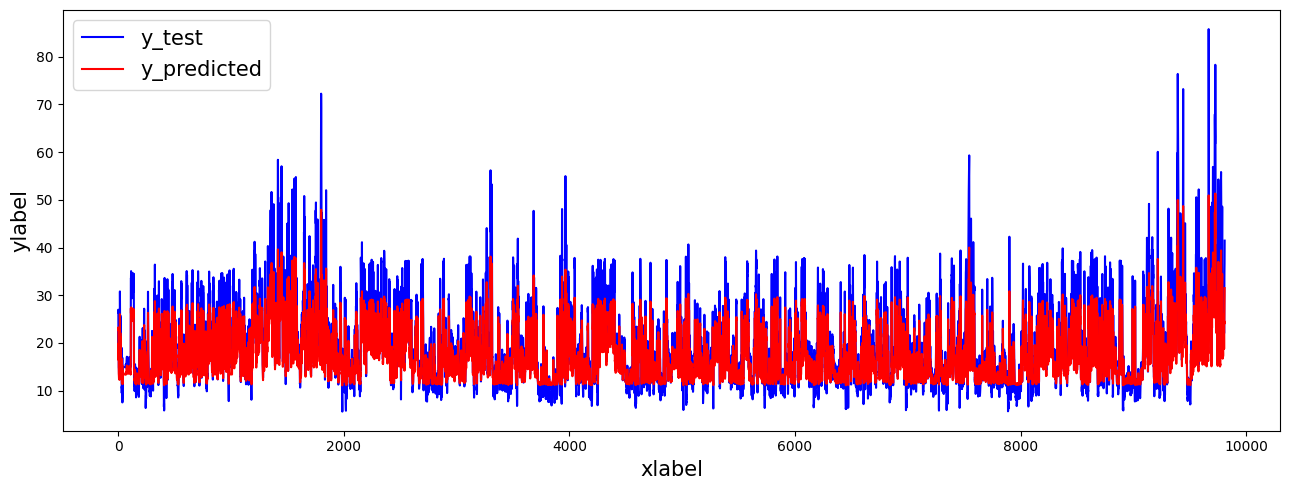

Day = 3
mae: 2.6168293868857626
mse: 15.397866472217617
rmse: 3.924011528043415
r2: 0.3805616511308413
mape: 0.1325853979383025
mnbe: -8.605733473066936
r_coeff: [0.98290406]


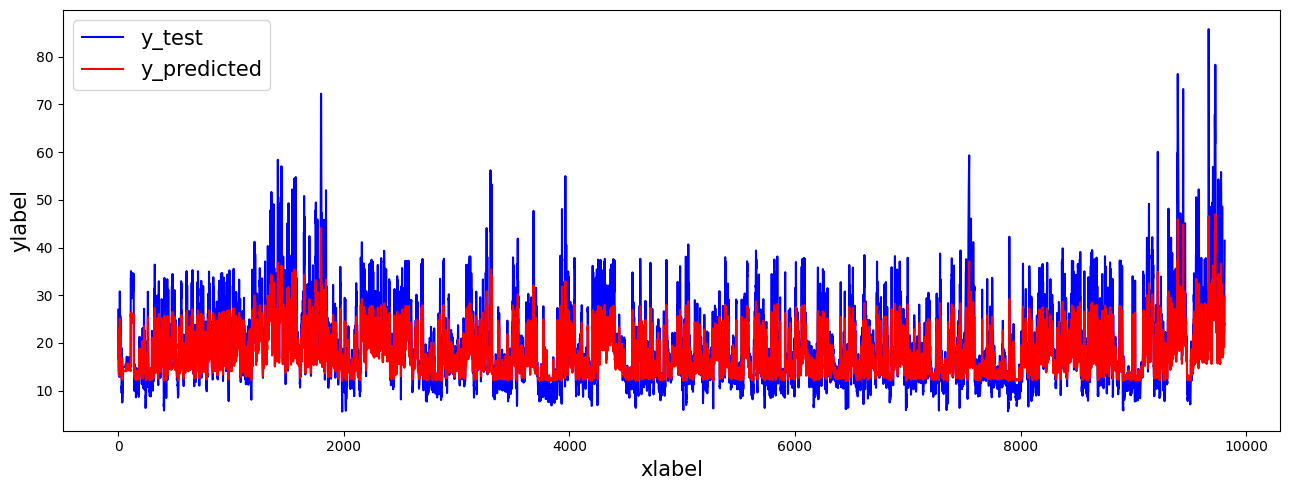

In [20]:
grus2s = define_grus2s_model(n_past, n_future, X_train.shape[-1], y_train.shape[-1], "grus2s_no_shift")

history = grus2s.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred = grus2s.predict(X_test)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

#### Shifted 1

Model: "grus2s_shifted_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 168, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ (None, 168, 128)  │     50,688 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ [(None, 64),      │     37,248 │ gru_4[0][0]       │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ gru_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 32)        │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_6     │ (None, 4, 32)     │          0 │ dense_12[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_6 (GRU)         │ (None, 4, 64)     │     18,816 │ repeat_vector_6[… │
│                     │                   │            │ gru_5[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_7 (GRU)         │ (None, 4, 128)    │     74,496 │ gru_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 4, 128)    │          0 │ gru_7[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_6  │ (None, 4, 1)      │        129 │ dropout_3[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 183,457 (716.63 KB)

 Trainable params: 183,457 (716.63 KB)

 Non-trainable params: 0 (0.00 B)

None

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 40s 110ms/step - loss: 0.0050 - val_loss: 0.0018
Epoch 2/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.0045 - val_loss: 0.0019
Epoch 3/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - loss: 0.0040 - val_loss: 0.0014
Epoch 4/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 5/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - loss: 0.0037 - val_loss: 0.0012
Epoch 6/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - loss: 0.0037 - val_loss: 0.0012
Epoch 7/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 8/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.0036 - val_loss: 0.0011
Epoch 9/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - loss: 0.0035 - val_loss: 0.0012
Epoch 10/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - loss: 0.0035 - val_loss: 0.0012
Epoch 11/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - loss: 0.0035 - val_loss: 0.0012
Epoch 12/100
249/2

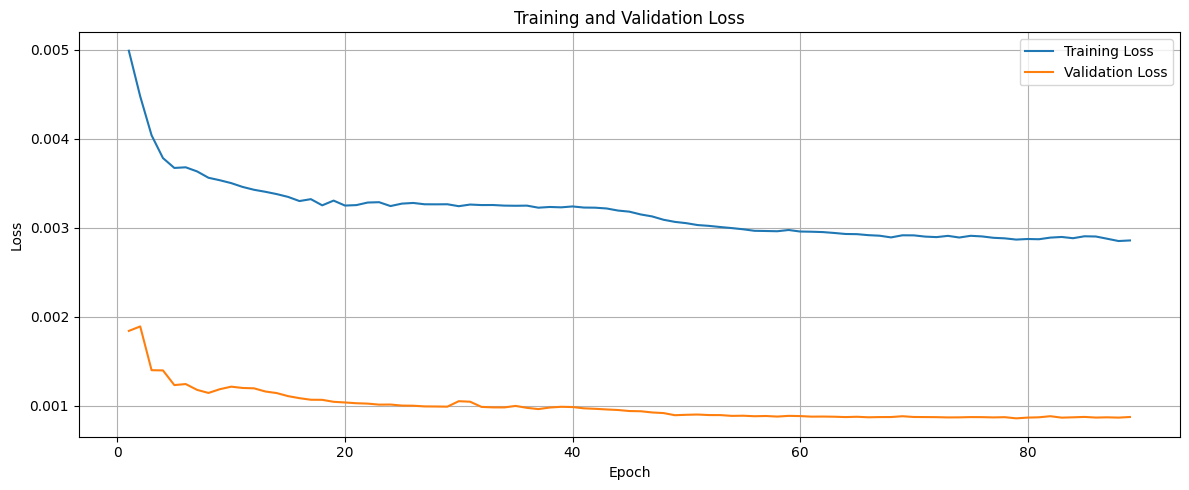

307/307 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step
Day = 0
mae: 3.0338648922595373
mse: 21.94816946378133
rmse: 4.6848873480353115
r2: 0.35543202292881415
mape: 0.16118527880890973
mnbe: -6.493755332682448
r_coeff: [0.85477599]


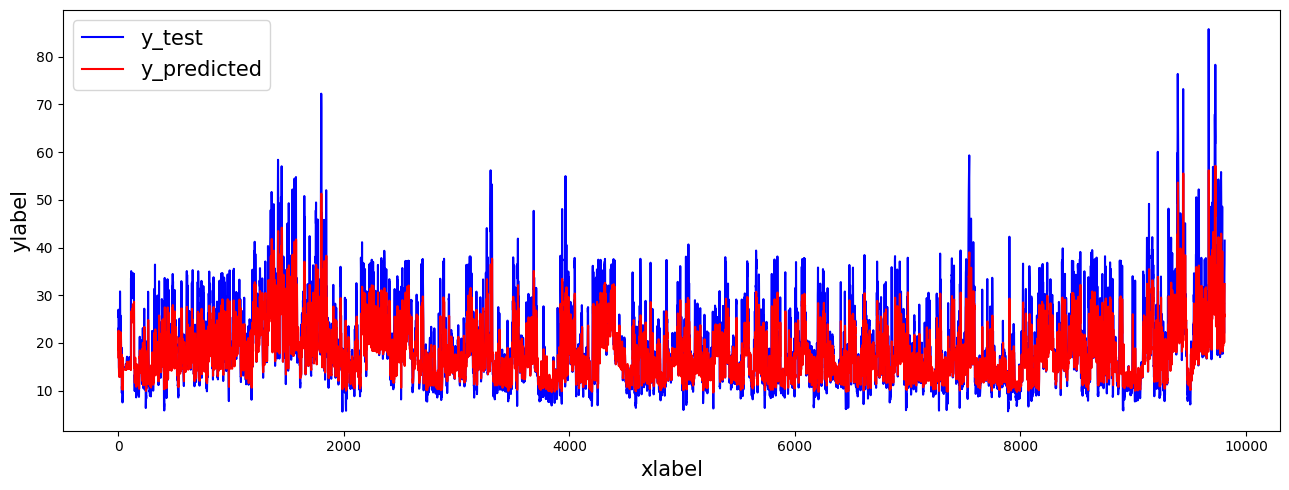

Day = 1
mae: 3.3630420137771946
mse: 26.400852305890343
rmse: 5.1381759707011145
r2: -0.02019684932441379
mape: 0.18101904068664046
mnbe: -8.422265234003088
r_coeff: [0.84425561]


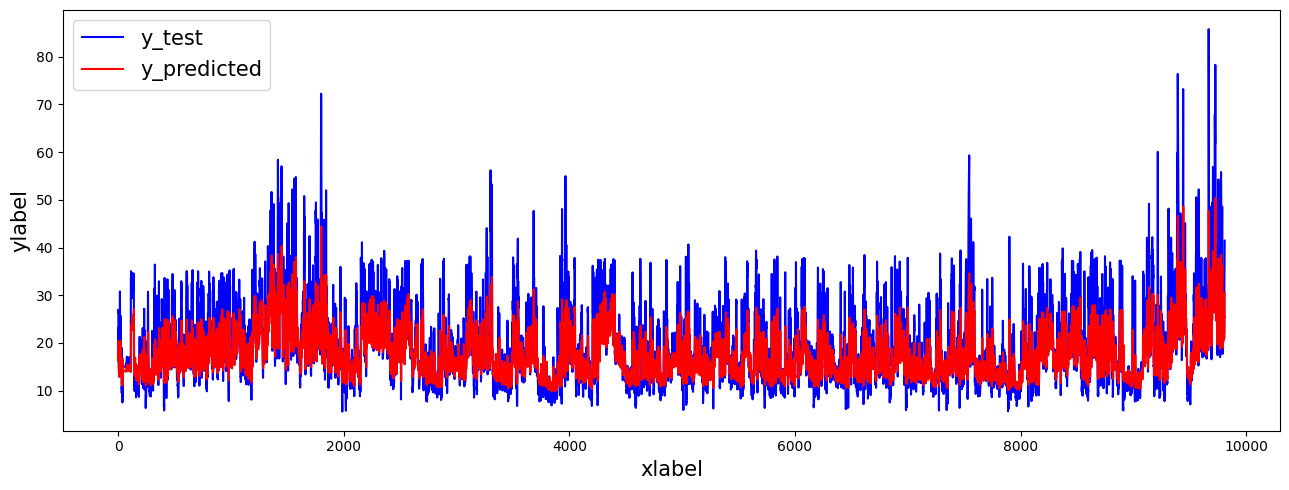

Day = 2
mae: 3.557211995605663
mse: 29.64217919681506
rmse: 5.444463168836305
r2: -0.3627765585534517
mape: 0.19182371340269497
mnbe: -8.822278089278289
r_coeff: [0.82941584]


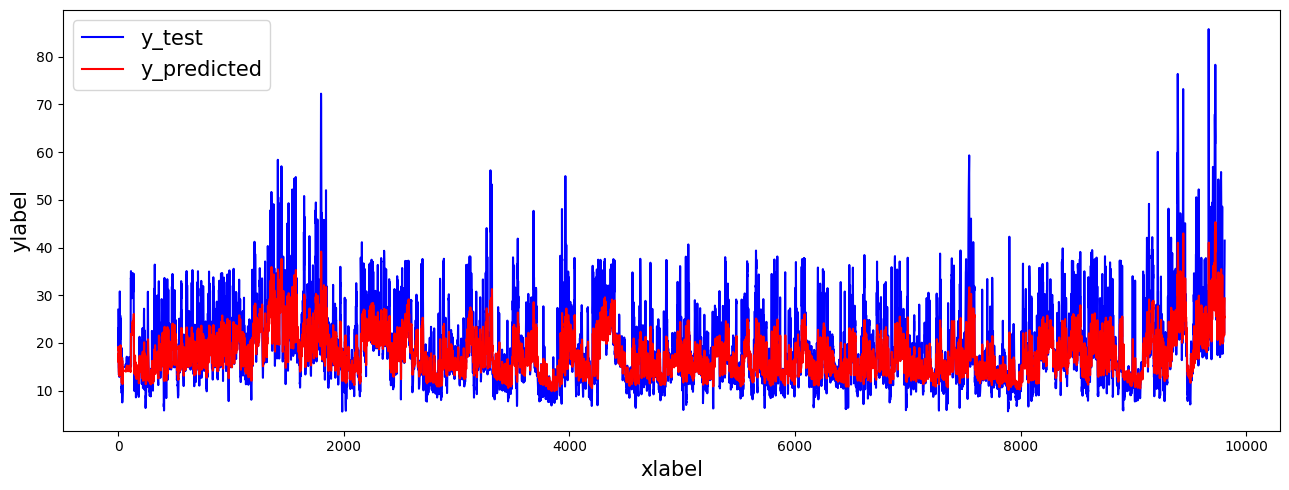

Day = 3
mae: 3.750955949097718
mse: 31.960872272670194
rmse: 5.653394756486601
r2: -0.7625575080122224
mape: 0.20107880910195164
mnbe: -7.3024363263308745
r_coeff: [0.81196756]


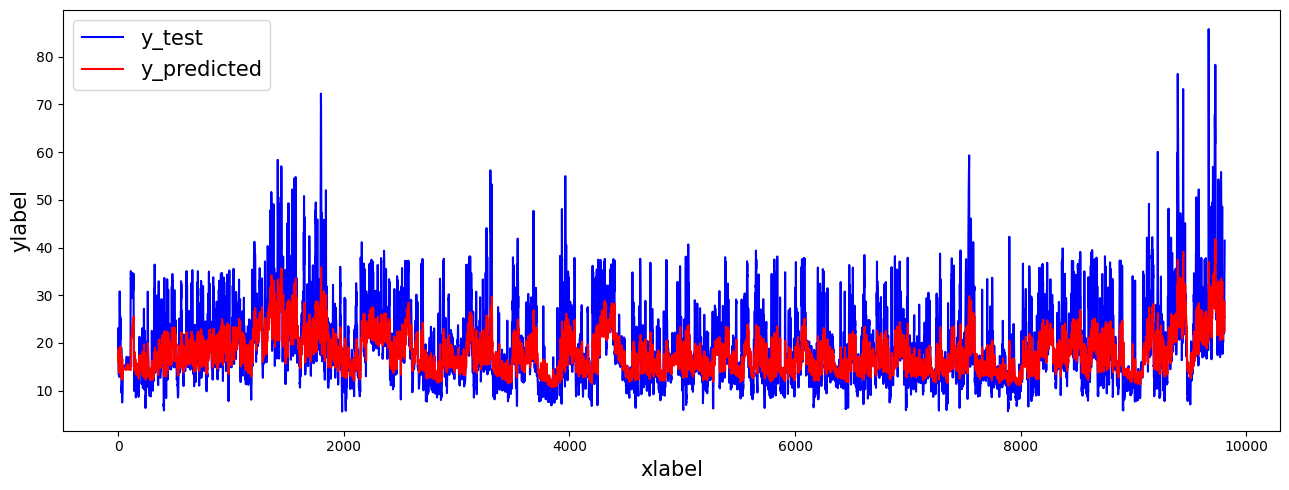

In [21]:
grus2s_shifted_1 = define_grus2s_model(n_past, n_future, X_train_shifted_1.shape[-1], y_train.shape[-1], "grus2s_shifted_1")

history = grus2s_shifted_1.fit(X_train_shifted_1, y_train_shifted_1,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred_shifted_1 = grus2s_shifted_1.predict(X_test_shifted_1)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test_shifted_1[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred_shifted_1[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

#### Shifted 2

Model: "grus2s_shifted_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 168, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_8 (GRU)         │ (None, 168, 128)  │     50,688 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_9 (GRU)         │ [(None, 64),      │     37,248 │ gru_8[0][0]       │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ gru_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 32)        │      2,080 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_7     │ (None, 4, 32)     │          0 │ dense_14[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_10 (GRU)        │ (None, 4, 64)     │     18,816 │ repeat_vector_7[… │
│                     │                   │            │ gru_9[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_11 (GRU)        │ (None, 4, 128)    │     74,496 │ gru_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 4, 128)    │          0 │ gru_11[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_7  │ (None, 4, 1)      │        129 │ dropout_5[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 183,457 (716.63 KB)

 Trainable params: 183,457 (716.63 KB)

 Non-trainable params: 0 (0.00 B)

None

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 39s 96ms/step - loss: 0.0051 - val_loss: 0.0017
Epoch 2/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - loss: 0.0049 - val_loss: 0.0014
Epoch 3/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - loss: 0.0045 - val_loss: 0.0017
Epoch 4/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - loss: 0.0043 - val_loss: 0.0014
Epoch 5/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 6/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - loss: 0.0041 - val_loss: 0.0013
Epoch 7/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 8/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 9/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 10/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 11/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 12/100
249/24

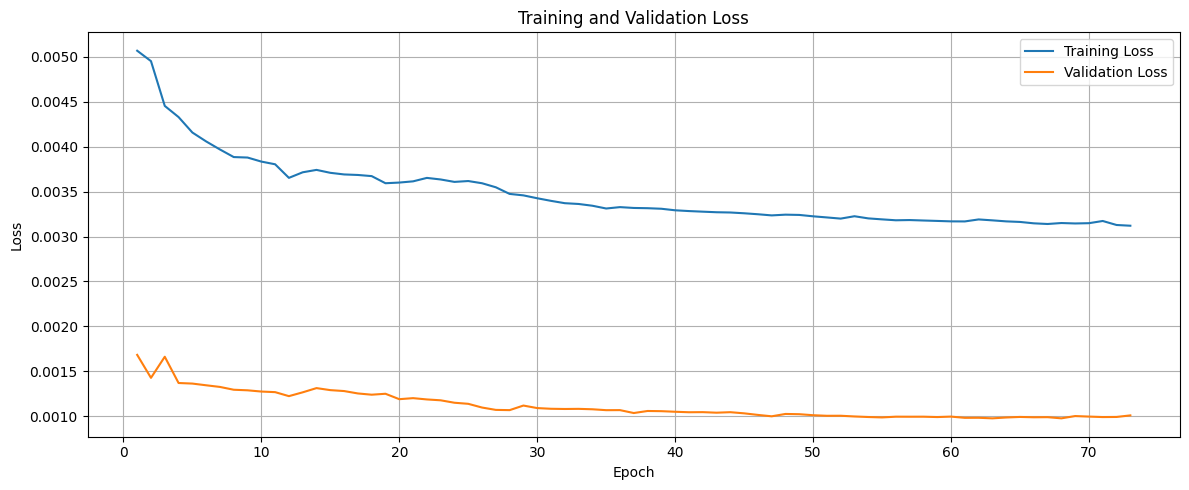

307/307 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step
Day = 0
mae: 4.05459221189651
mse: 35.794650110815155
rmse: 5.982863036274118
r2: -0.28587861250380153
mape: 0.22590056106871237
mnbe: -8.852023921205353
r_coeff: [0.73262287]


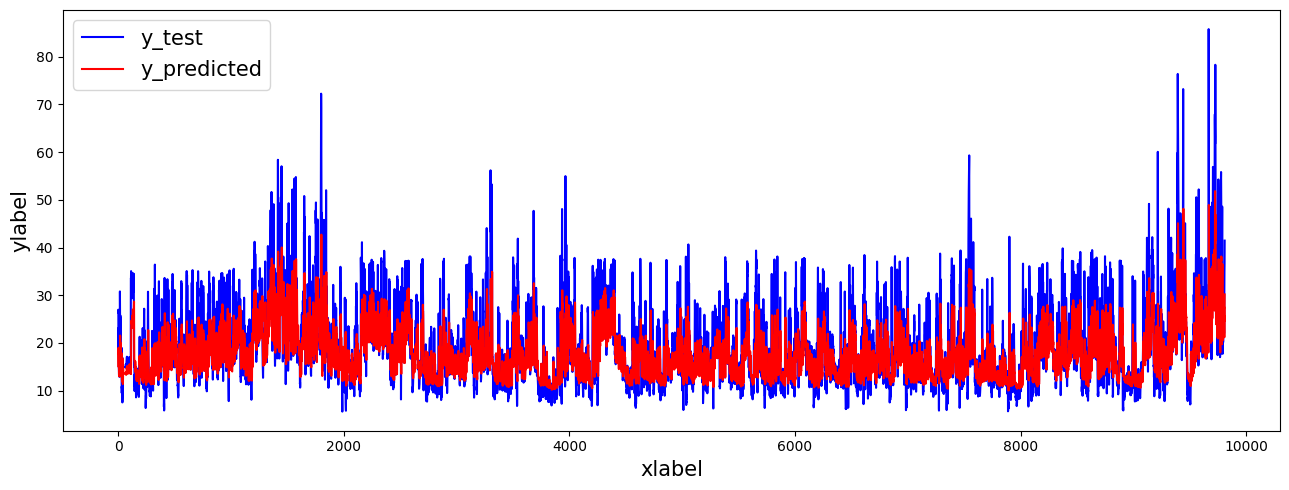

Day = 1
mae: 4.169573795758372
mse: 37.88258908604775
rmse: 6.154883352757203
r2: -0.5384007909870945
mape: 0.23441570862169114
mnbe: -9.819321495266374
r_coeff: [0.72299771]


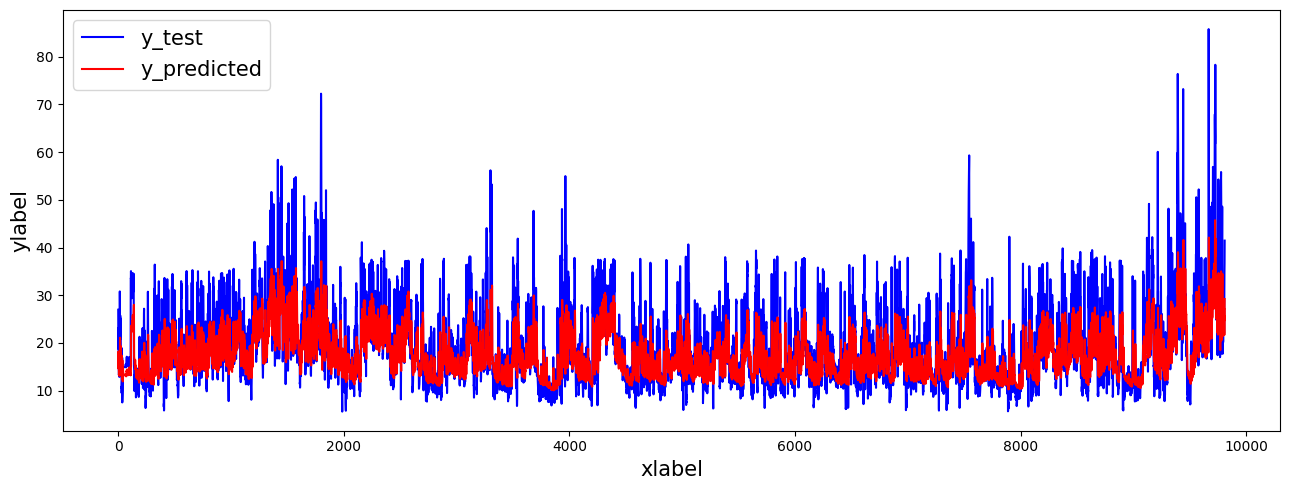

Day = 2
mae: 4.2600572249550455
mse: 39.33521634021845
rmse: 6.2717793599758
r2: -0.872259888143367
mape: 0.237526252003361
mnbe: -9.28325905541182
r_coeff: [0.71144832]


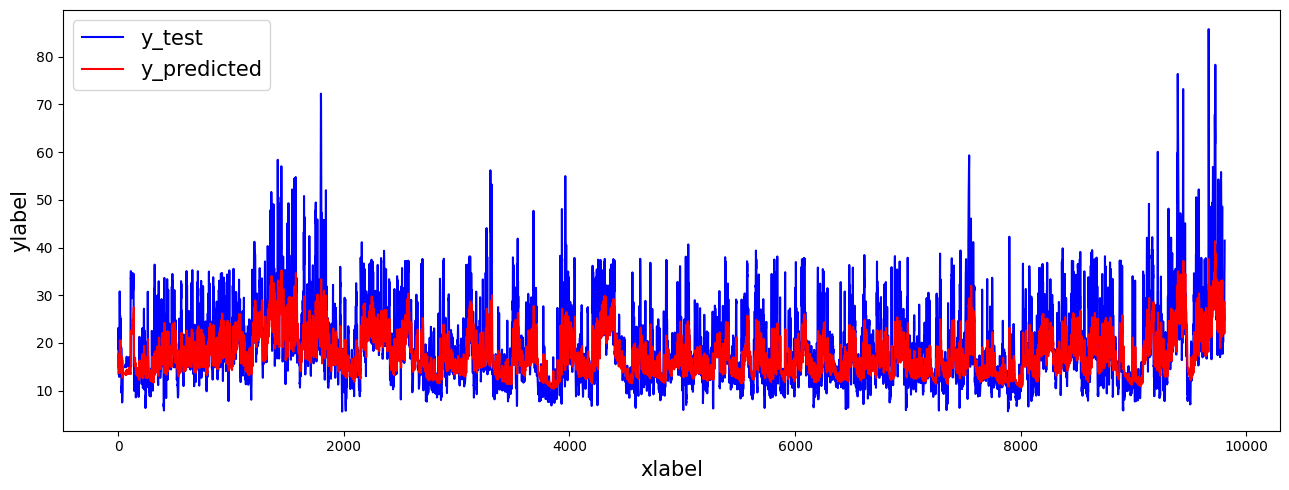

Day = 3
mae: 4.361122667194692
mse: 40.38830618268121
rmse: 6.3551794768268515
r2: -1.2916855656064783
mape: 0.23950662835924863
mnbe: -7.7674835776408395
r_coeff: [0.69972146]


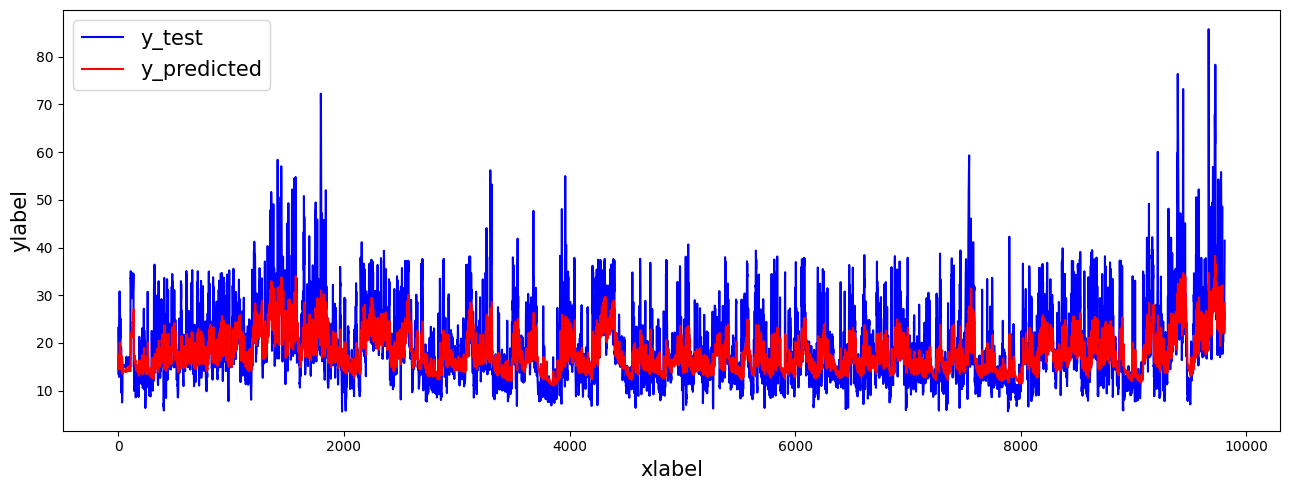

In [22]:
grus2s_shifted_2 = define_grus2s_model(n_past, n_future, X_train_shifted_2.shape[-1], y_train.shape[-1], "grus2s_shifted_2")

history = grus2s_shifted_2.fit(X_train_shifted_2, y_train_shifted_2,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred_shifted_2 = grus2s_shifted_2.predict(X_test_shifted_2)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test_shifted_2[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred_shifted_2[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

#### Shifted 3

Model: "grus2s_shifted_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 168, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_12 (GRU)        │ (None, 168, 128)  │     50,688 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_13 (GRU)        │ [(None, 64),      │     37,248 │ gru_12[0][0]      │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ gru_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 32)        │      2,080 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_8     │ (None, 4, 32)     │          0 │ dense_16[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_14 (GRU)        │ (None, 4, 64)     │     18,816 │ repeat_vector_8[… │
│                     │                   │            │ gru_13[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_15 (GRU)        │ (None, 4, 128)    │     74,496 │ gru_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 4, 128)    │          0 │ gru_15[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, 4, 1)      │        129 │ dropout_7[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 183,457 (716.63 KB)

 Trainable params: 183,457 (716.63 KB)

 Non-trainable params: 0 (0.00 B)

None

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 69s 218ms/step - loss: 0.0052 - val_loss: 0.0020
Epoch 2/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 36s 143ms/step - loss: 0.0050 - val_loss: 0.0014
Epoch 3/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - loss: 0.0049 - val_loss: 0.0015
Epoch 4/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - loss: 0.0047 - val_loss: 0.0016
Epoch 5/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 42s 167ms/step - loss: 0.0044 - val_loss: 0.0014
Epoch 6/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - loss: 0.0044 - val_loss: 0.0016
Epoch 7/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - loss: 0.0043 - val_loss: 0.0016
Epoch 8/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - loss: 0.0042 - val_loss: 0.0016
Epoch 9/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - loss: 0.0041 - val_loss: 0.0016
Epoch 10/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - loss: 0.0040 - val_loss: 0.0015
Epoch 11/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - loss: 0.0040 - val_loss: 0.0015
Epoch 12/100


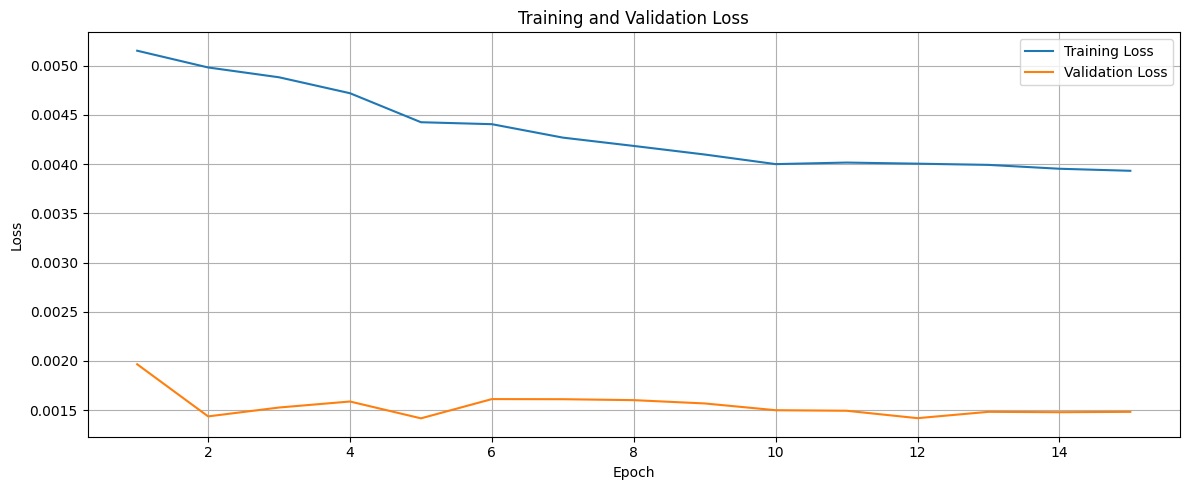

307/307 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step
Day = 0
mae: 5.942173725956426
mse: 71.73302549869479
rmse: 8.469535140649384
r2: -42.265866499713326
mape: 0.36787192284515075
mnbe: -17.889894081899175
r_coeff: [0.52662369]


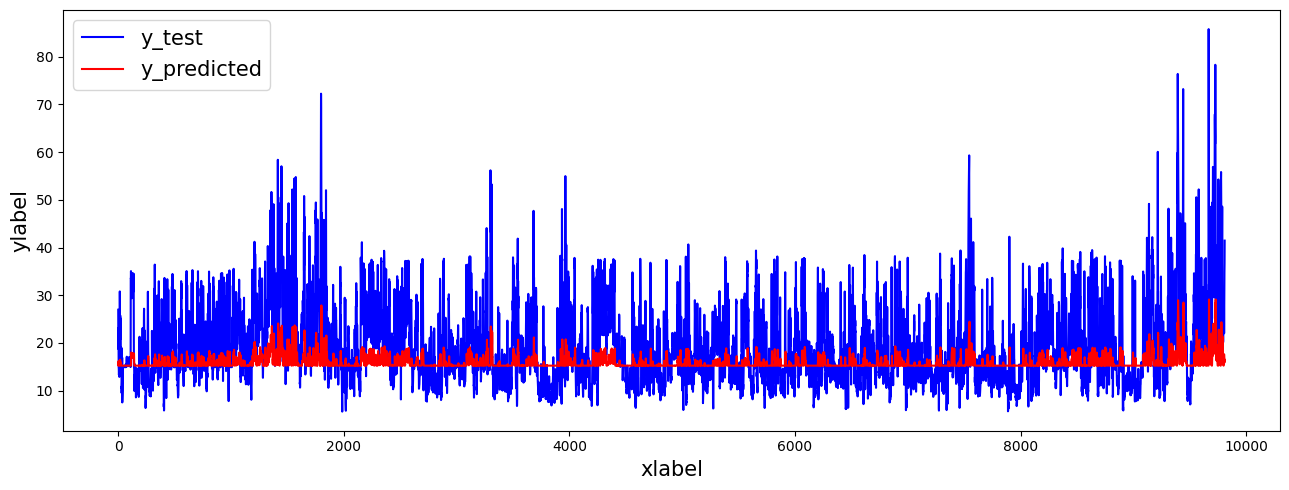

Day = 1
mae: 6.22727418613723
mse: 79.70671989344318
rmse: 8.927862000134365
r2: -93.47695531878597
mape: 0.4043829290675279
mnbe: -21.64436399904211
r_coeff: [0.5243391]


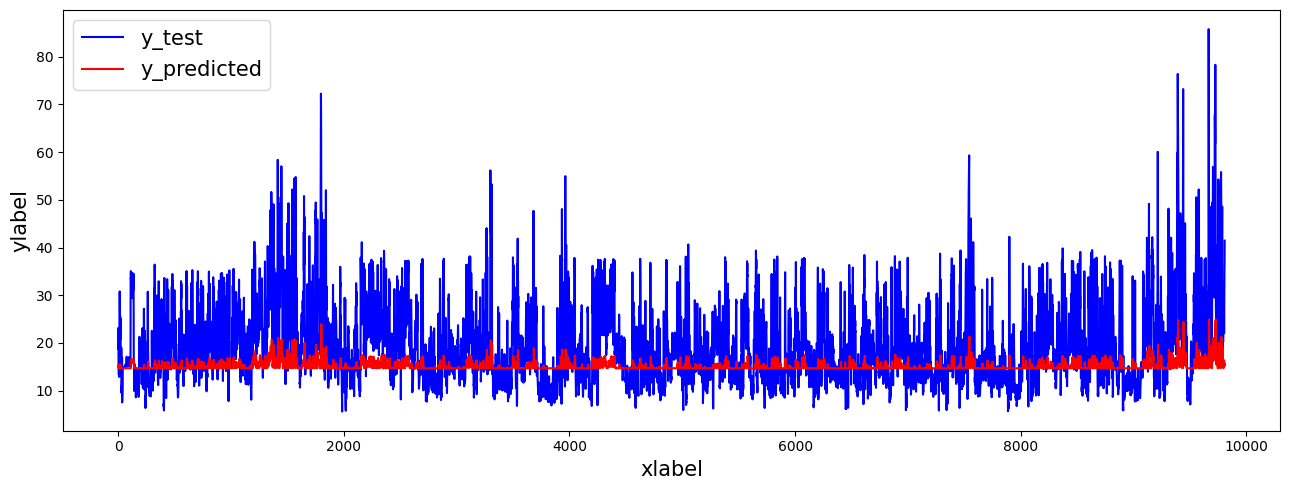

Day = 2
mae: 6.53769475968548
mse: 88.06523221559787
rmse: 9.38430776432646
r2: -288.85473732948606
mape: 0.4450101837331093
mnbe: -24.91522615222342
r_coeff: [0.52163559]


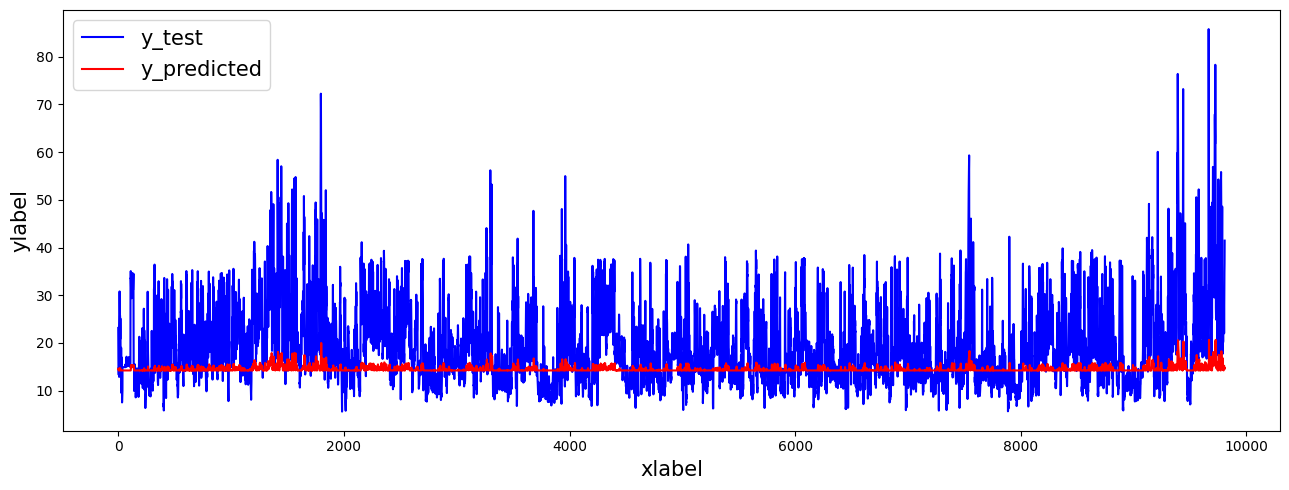

Day = 3
mae: 6.736680668915071
mse: 93.50110609852975
rmse: 9.669596997731071
r2: -955.8807204093597
mape: 0.4725823795792239
mnbe: -26.767978298697926
r_coeff: [0.52043796]


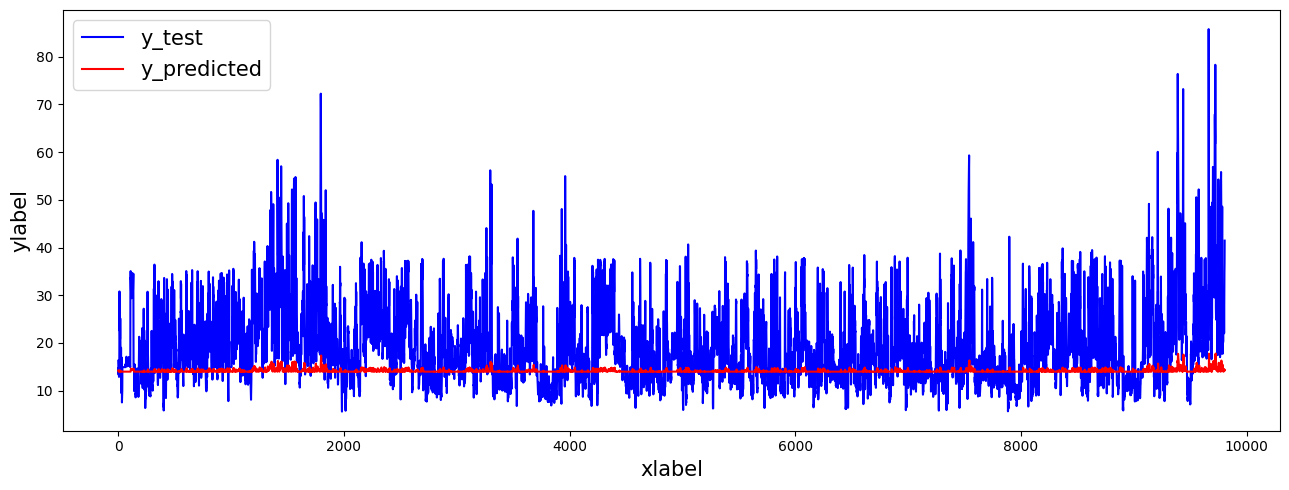

In [23]:
grus2s_shifted_3 = define_grus2s_model(n_past, n_future, X_train_shifted_3.shape[-1], y_train.shape[-1], "grus2s_shifted_3")

history = grus2s_shifted_3.fit(X_train_shifted_3, y_train_shifted_3,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred_shifted_3 = grus2s_shifted_3.predict(X_test_shifted_3)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test_shifted_3[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred_shifted_3[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

#### Shifted 4

In [24]:
grus2s_shifted_4 = define_grus2s_model(n_past, n_future, X_train_shifted_4.shape[-1], y_train.shape[-1], "grus2s_shifted_4")

history = grus2s_shifted4.fit(X_train_shifted_4, y_train_shifted_4,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred_shifted_4 = grus2s_shifted4.predict(X_test_shifted_4)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test_shifted_4[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred_shifted_4[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

Model: "grus2s_shifted_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 168, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_16 (GRU)        │ (None, 168, 128)  │     50,688 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_17 (GRU)        │ [(None, 64),      │     37,248 │ gru_16[0][0]      │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ gru_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 32)        │      2,080 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_9     │ (None, 4, 32)     │          0 │ dense_18[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_18 (GRU)        │ (None, 4, 64)     │     18,816 │ repeat_vector_9[… │
│                     │                   │            │ gru_17[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_19 (GRU)        │ (None, 4, 128)    │     74,496 │ gru_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 4, 128)    │          0 │ gru_19[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, 4, 1)      │        129 │ dropout_9[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 183,457 (716.63 KB)

 Trainable params: 183,457 (716.63 KB)

 Non-trainable params: 0 (0.00 B)

None

NameError: name 'grus2s_shifted4' is not defined

In [ ]:
stop

### CNN-LSTM Seq2seq

In [ ]:
# Encoder layers
encoder_inputs = Input(shape=(n_past, n_features))
encoder_cnn_1 = Conv1D(filters=128, kernel_size=2, activation="relu")(encoder_inputs)
encoder_max_pooling_1 = MaxPooling1D(pool_size=2)(encoder_cnn_1)
encoder_cnn_2 = Conv1D(filters=64, kernel_size=2, activation="relu")(encoder_max_pooling_1)
encoder_max_pooling_2 = MaxPooling1D(pool_size=2)(encoder_cnn_2)
encoder_lstm, state_h, state_c = LSTM(64, return_state=True, activation="relu")(encoder_max_pooling_2)
encoder_dropout = Dropout(0.2)(encoder_lstm)
encoder_dense = Dense(latent_dim)(encoder_dropout)
# Repeat layer
decoder_repeat_vector = RepeatVector(n_future)(encoder_dense)
# Decoder layers
decoder_lstm_1 = LSTM(64, return_sequences=True, activation="relu")(decoder_repeat_vector, initial_state=[state_h, state_c])
decoder_dropout = Dropout(0.2)(decoder_lstm_1)
decoder_outputs = TimeDistributed(Dense(n_label))(decoder_dropout)
# Compile the model
cnncnnlstms2smodel = Model(encoder_inputs, decoder_outputs)
# Compile the model
cnnlstms2smodel = Model(encoder_inputs, decoder_outputs)
cnnlstms2smodel.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
display(cnnlstms2smodel.summary())

# Fit model
history = cnnlstms2smodel.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    #EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred = cnnlstms2smodel.predict(X_test)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

## Evaluation board

In [ ]:
pd.DataFrame(evaluation_board)